In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import copy
from Bio import SeqIO

### 0. Outils

- **notebook** : un type de fichier permettant d'intercaler des section de code et des section de texte, permet aussi d'afficher les plots directements (pratique pour décrire une analyse)
- **pyvcf** : librairie python pour parser des fichier vcf et récupérer les variants qui y sont référencé
- **Biopython** : librairie de bioinformatique qui nous permet ici de parser le fichier fasta contenant toutes les ORF du virus
- **pandas** : Permet de traiter des donnés tabulaires (type csv) efficacement et facilement (accession, filtrage, trie, ...) dans un objet appelé data_nf1Frame
- **seaborn** : Permet de réaliser des graphiques facilement à partir de DataFrame

### 1. Récupération des données

Les variants structuraux de tous les échantillons pour tous les passage ont été récupérés au préalable sur le cluster et regroupés dans un fichier csv. Chaque variants est représenté par une donné avec les entrées suivantes:
- **id** : identifiant de la variation dans le fichier vcf
- **svtype** : type de variant (INS, DEL, INV, DUP)
- **pos** : position de début de la variation
- **end** : position de fin de la variation (pour une insertion pos = end)
- **svlen** : taille de la variation (négatif pour les délétions)
- **alt** : séquence du variant en cas d'insertion
- **dr, dv** : profondeur de read mappant sur la référence (dr) et mappant sur le variant (dv)
- **depth** : profondeur de read total sur cette région du génome (dr + dv)
- **af** : fréquence allélique ( dv / depth : proportion de read supportant cette inversion par rapport au reads mappés sur cette région)
- **sample** : échantillon d'origine (1 à 10)
- **iteration** : passage d'origine (15 à 90)
- **group** : les variants identiques sont regroupés avec un identifiant identique (voir ci dessous)

#### Groupement des variants identiques

On veut pouvoir repérer les différentes occurences d'un même variant dans différentes expériences.
Pour cela les variants sont comparé entre eux en se basant sur les éléments suivants, qui doivent être identiques :
- La position de début
- La position de fin 
- La séquence alternative pour les insertions

Il a été choisis de grouper les variants seulement lorsqu'ils sont exactement identique pour être certain qu'ils ont le même impacte sur le fonctionnement biologique. Par ailleurs, cette méthode identifie de nombreuses occurences d'un même variant, ce qui montre que ce seuil est pertinent : pour 2 457 variants, 779 groupes ont été identifiés


In [2]:
data = pd.read_csv('../data/variants.csv', index_col="index")
data["choc"] = data.apply(lambda x: "cold" if x["sample"] <= 5 else "heat", axis=1)

data["iteration"] = pd.Categorical(data["iteration"])
data["sample"] = pd.Categorical(data["sample"])
data["group"] = pd.Categorical(data["group"])
data["svtype"] = pd.Categorical(data["svtype"])
data["choc"] = pd.Categorical(data["choc"])

data.head()

,pos,id,svtype,svlen,end,af,dv,dr,depth,alt,sample,iteration,group,choc
index,,,,,,,,,,,,,,
0,1,Sniffles2.DUP.705S0,DUP,272677,272678,0.0,0,0,0,NaN,1,15,0,cold
1,1,Sniffles2.DUP.3B3S0,DUP,272677,272678,0.0,0,0,0,NaN,1,30,0,cold
2,1,Sniffles2.DUP.29FS0,DUP,272677,272678,0.0,0,0,0,NaN,1,50,0,cold
3,1,Sniffles2.DUP.6ADS0,DUP,272677,272678,0.0,0,0,0,NaN,2,15,0,cold
4,1,Sniffles2.DUP.1AS0,DUP,272677,272678,0.0,0,0,0,NaN,2,30,0,cold


In [3]:
data_init = pd.DataFrame(
    columns = data.columns, data = copy.deepcopy(data.values)
)
data_init["iteration"] = pd.Categorical(data["iteration"])
data_init["sample"] = pd.Categorical(data["sample"])
data_init["group"] = pd.Categorical(data["group"])
data_init["svtype"] = pd.Categorical(data["svtype"])

### 2. Filtrage des données

#### A. Fréquence allélique et profondeur

Pour déterminer des filtres de fréquences alléliques et de profondeur minimum qui soit pertinent on regarde quelles sont les valeurs observés dans les différents passage. Il est nécessaire de regarder tous les passages indépendament puisque la qualité globale du séquencage diffère d'un passage à l'autre. On choisiras cependant un seuil fixe pour l'ensemble des passage afin de rester consistant.

Pour les fréquences allélique, on voit sur l'histogramme on remarque le "coude" de la distribution à 0.05 (ligne rouge) : comme une grande quantité d'observations se situe en dessous de ce seuil, il est pertinent de considérer que ces observations sont les moins significatives.

Ce raisonnement est plus compliqué à appliquer sur les profondeur qui ne sont pas aussi distinctement répartis, on peut afficher des violin plots pour voir la distribution de chaque passage. La largeur du graphique représente la proportion de reads à une valeur donnée de profondeur, un boxplot est représenté à l'interieur en noir. On ne peut pas choisir un filtre trop restrictif car les données de P60 sont assez mal supportés, un filtre à 300 permet de conserver 50% des variants de ce passage (coupe sur la médiane).

Le dernier graphique représente chaque variant par un point positioné en fonction de sa profondeur (absysses) sa fréquence allélique (ordonnées).

Enfin avec des seuils à 0.05 et 300 on conservera des variants supportés par 15 reads minimum (0.05 * 300).

**Remarque :** ce sont les groupes de variants (cf description plus haut) identiques qui sont filtrés et non les variants individuellement, par exemple si un variant est présent à P15 et ne remplis pas les conditions pour passer le filtre, mais qu'il est aussi présent à P50, cette fois en fréquence et en profondeur suffisante, les deux occurences seront conservé.

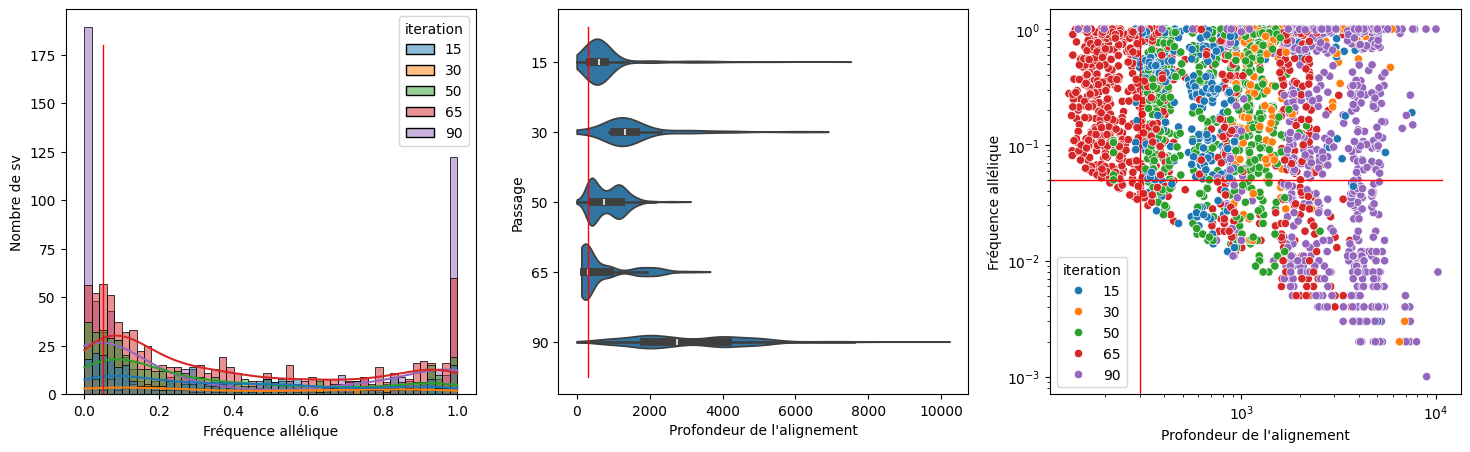

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))
sns.histplot(data=data, x="af", hue="iteration", kde=True, bins=50, ax=ax1)
sns.violinplot(data=data, x="depth", y="iteration", density_norm="area", ax=ax2, cut=0)
sns.scatterplot(data=data[(data["iteration"].isin([90, 15, 65, 30, 50])) & (data["depth"] > 50)], x="depth", y="af", hue="iteration", ax=ax3)

ax1.plot([0.05, 0.05], [0.0, 180], 'r-', lw=1)
ax1.set_xlabel("Fréquence allélique")
ax1.set_ylabel("Nombre de sv")

ax2.plot([300.0, 300.0], [ax2.get_ylim()[0], ax2.get_ylim()[1]], 'r-', lw=1)
ax2.set_xlabel("Profondeur de l'alignement")
ax2.set_ylabel("Passage")

ax3.plot([ax3.get_xlim()[0], ax3.get_xlim()[1]], [0.05, 0.05], 'r-', lw=1)
ax3.plot([300.0, 300.0], [ax3.get_ylim()[0], ax3.get_ylim()[1]], 'r-', lw=1)
ax3.set_xlabel("Profondeur de l'alignement")
ax3.set_ylabel("Fréquence allélique")
ax3.set_yscale("log")
ax3.set_xscale("log")

plt.show()

In [5]:
data = data.groupby(["group"], observed=True).filter(lambda x: x["af"].max() > 0.05 and x["depth"].max() > 300)

#### B. Repérer les outliers

Des outliers sont des données inattendu qui peuvent possiblement être causé par des bugs. Dans notre cas on sait que les régions au début et à la fin du génome sont répétés, ce qui peut conduire à détecter de larges insertions dans ces régions.
Afficher la distribution des longueurs de variants dans un box plot nous permet de les repérer pour les filtrer correctement. 

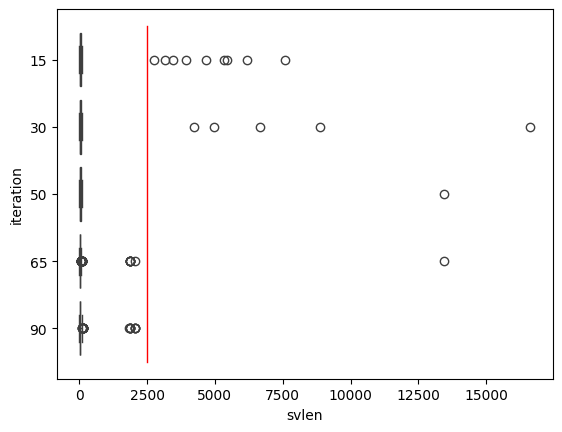

In [6]:
fig, ax = plt.subplots()
sns.boxplot(data=data[(30000 < data["pos"]) & (data["pos"] < 270000)], x=abs(data[(30000 < data["pos"]) & (data["pos"] < 270000)]["svlen"]), y="iteration", showfliers=True, ax=ax)
plt.plot([2500.0, 2500.0], [ax.get_ylim()[0], ax.get_ylim()[1]], 'r-', lw=1)
plt.show()

En observant plus en détails ces donnés on remarque que soit ces variants sont positionnés au bornes du génomes, soit ce sont des régions répétés.
Ci dessous tous les variants d'une taille superieur à 2 500 entre les positions 20 000 et 280 000.

On décidera donc de filtrer les variants qui ont une taille supérieur à 2 500

In [7]:
def truncate(x):
    if x["svtype"] == "INS":
        #x["alt"] = x["alt"][0:min(len(x["alt"]), 50)]
        x["alt"] = x["alt"][max(len(x["alt"]) - 50, 0):] 
    return x

outliers = data.copy(deep=True)
outliers["svlen"] = abs(outliers["svlen"])
outliers = outliers[(outliers["svlen"] > 2500) & (outliers["pos"] > 20000) & (outliers["pos"] < 280000)]
outliers = outliers.sort_values("pos").sort_values("svlen", ascending=False)

outliers = outliers.apply(truncate, 1)
outliers

,pos,id,svtype,svlen,end,af,dv,dr,depth,alt,sample,iteration,group,choc
index,,,,,,,,,,,,,,
2453,272448,Sniffles2.INS.2A4S0,INS,23059,272448,1.000,306,0,306,<INS>,7,90,776,heat
1774,196282,Sniffles2.INS.BS0,INS,16622,196282,0.808,3164,753,3917,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,2,30,584,cold
2019,229512,Sniffles2.DEL.3A2S0,DEL,13429,242941,0.119,41,303,344,NaN,7,65,668,heat
2018,229512,Sniffles2.DEL.31FS0,DEL,13429,242941,0.009,11,1172,1183,NaN,7,50,668,heat
1333,138818,Sniffles2.INS.DS0,INS,8855,138818,1.000,5949,0,5949,CTCCTTGGGGATCTCGTAGAAGAGCGGTATCTCAACTGTCGTGCCG...,6,30,445,heat
1082,85419,Sniffles2.INS.10S0,INS,7568,85419,0.764,1502,464,1966,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGCGCTAT...,8,15,365,heat
1447,155479,Sniffles2.INS.FS0,INS,6668,155479,1.000,3401,0,3401,GCGGTGGCGGCGGCAGGGGGTTGAGGAGTCCTCTGGGGCTGAGCGG...,9,30,470,heat
1334,142608,Sniffles2.INS.1ES0,INS,6168,142608,0.576,1779,1310,3089,GGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGGG...,10,15,446,heat
303,22914,Sniffles2.INS.DS0,INS,5867,22914,0.339,1091,2125,3216,GAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGAGA...,8,30,119,heat


In [8]:
data = data[abs(data["svlen"]) < 2500]

#### C. Impacte du filtrage

On superpose les données aux différentes étapes du filtrage pour comprendre l'impacte et voir la quantité de données conservés.

Proportion de variants conservés : 0.7891737891737892


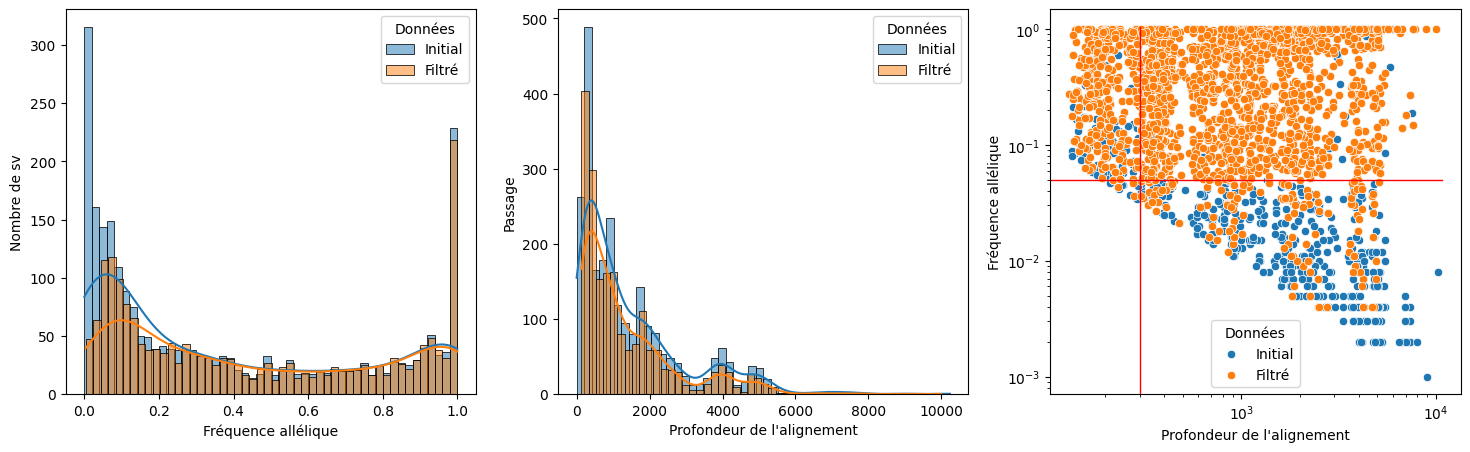

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.histplot(data=data_init, x="af", label="Initial", kde=True, bins=50, ax=ax1)
sns.histplot(data=data, x="af", label="Filtré", kde=True, bins=50, ax=ax1)
ax1.legend(title="Données")

sns.histplot(data=data_init, x="depth", label="Initial", kde=True, bins=50, ax=ax2)
sns.histplot(data=data, x="depth", label="Filtré", kde=True, bins=50, ax=ax2)
ax2.legend(title="Données")

sns.scatterplot(data=data_init[(data_init["depth"] > 50)], x="depth", y="af", label="Initial", ax=ax3)
sns.scatterplot(data=data[(data["depth"] > 50)], x="depth", y="af", label="Filtré", ax=ax3)
ax3.legend(title="Données")

ax1.set_xlabel("Fréquence allélique")
ax1.set_ylabel("Nombre de sv")

ax2.set_xlabel("Profondeur de l'alignement")
ax2.set_ylabel("Passage")

ax3.plot([ax3.get_xlim()[0], ax3.get_xlim()[1]], [0.05, 0.05], 'r-', lw=1)
ax3.plot([300.0, 300.0], [ax3.get_ylim()[0], ax3.get_ylim()[1]], 'r-', lw=1)
ax3.set_xlabel("Profondeur de l'alignement")
ax3.set_ylabel("Fréquence allélique")
ax3.set_yscale("log")
ax3.set_xscale("log")

print("Proportion de variants conservés :", len(data)/len(data_init))
plt.show()

### 2.1 Extraire les variants qui interfèrent avec un ORF connu

Pour cela on extrait tous les o connues du virues à partir d'un fichier FASTA. Si une variation structurelle chevauche un ou plusieurs o, on noteras lesquel.

In [10]:
orfs = []

for seq in SeqIO.parse("../ORF.fasta", "fasta"):
    header = seq.description

    locus_tag = header.split("[")[1][:-2].split("=")[1]
    protein_id = header.split("[")[4][:-2].split("=")[1]

    locations = header.split("[")[5][:-2].split("(")[-1].split("=")[-1].split(")")[0].split(",")
    locations = [inter.split("..") for inter in locations]

    complement = 'complement' in header.split("[")[5]
    join = 'join' in header.split("[")[5]

    to_add = [{'locus_tag': locus_tag, 'protein_id': protein_id, 'location': loc, 'complement': complement, 'join': join} for loc in locations]
    orfs += to_add


def intersected_orfs(pos, end):
    result = []
    for o in orfs:
        if min(end, int(o["location"][1])) - max(pos, int(o["location"][0])) > 0:
            result.append(o["locus_tag"])
    return result

In [11]:
data["orfs"] = data.apply(lambda x: intersected_orfs(x["pos"], x["end"]), axis=1)
data[data["orfs"].astype(bool)].head()

,pos,id,svtype,svlen,end,af,dv,dr,depth,alt,sample,iteration,group,choc,orfs
index,,,,,,,,,,,,,,,
54,9457,Sniffles2.DEL.1D5S0,DEL,-17,9474,0.594,899,614,1513,NaN,10,90,17,heat,[CyHV3_ORF5_1]
668,47057,Sniffles2.DEL.1E6S0,DEL,-1871,48928,0.016,15,899,914,NaN,1,65,271,cold,"[CyHV3_ORF25, CyHV3_ORF26, CyHV3_ORF27]"
669,47057,Sniffles2.DEL.34BS0,DEL,-1871,48928,0.023,91,3928,4019,NaN,1,90,271,cold,"[CyHV3_ORF25, CyHV3_ORF26, CyHV3_ORF27]"
670,47057,Sniffles2.DEL.2C4S0,DEL,-1871,48928,0.403,904,1340,2244,NaN,2,65,271,cold,"[CyHV3_ORF25, CyHV3_ORF26, CyHV3_ORF27]"
671,47057,Sniffles2.DEL.263S0,DEL,-1871,48928,0.194,364,1513,1877,NaN,3,65,271,cold,"[CyHV3_ORF25, CyHV3_ORF26, CyHV3_ORF27]"


### 3. Exploration de P90

**Remarque :** Le code suivant peut être appliqué aux autres passages simplement en changant la variale ioi

In [15]:
ioi = 90 # Iteration of interests

data_oi = data[data["iteration"] == ioi]
data_oi_orf = data_oi[data_oi["orfs"].astype(bool)]

#### A. Distributions des variants

On veut d'abord mener une analyse descriptive pour voir les différents variants qui compose les échantillons du passage P90, leur quantités, leurs positions et leur tailles.

On remarque que les échalntillons du choc chaud sont beaucoup plus riche en délétion (3ème plot) alors que le nombre d'insertions reste très stable entre les différents échantillons (2ème plot). À ce stade on peut supposer que les délétions sont plus corrélés au choc thermique que les insertions, elles ont pu être sélectionnés dasn le chaud ou éliminés dans le froid.

Si on suppose que la probabilité d'apparition d'une insertion et d'une délétions sont identiques (est ce que c'est vrai ?), on pourrait alors imaginer que les délétions sont contre-sélectionnés par le choc froid.

Enfin on remarque déjà ici que l'échantillon 3 semble plus homogène avec le groupe chaud et que l'échantillon 9 semble plus homogène avec le groupe froid. Se pourrait-il que les tags ai été échangés ?

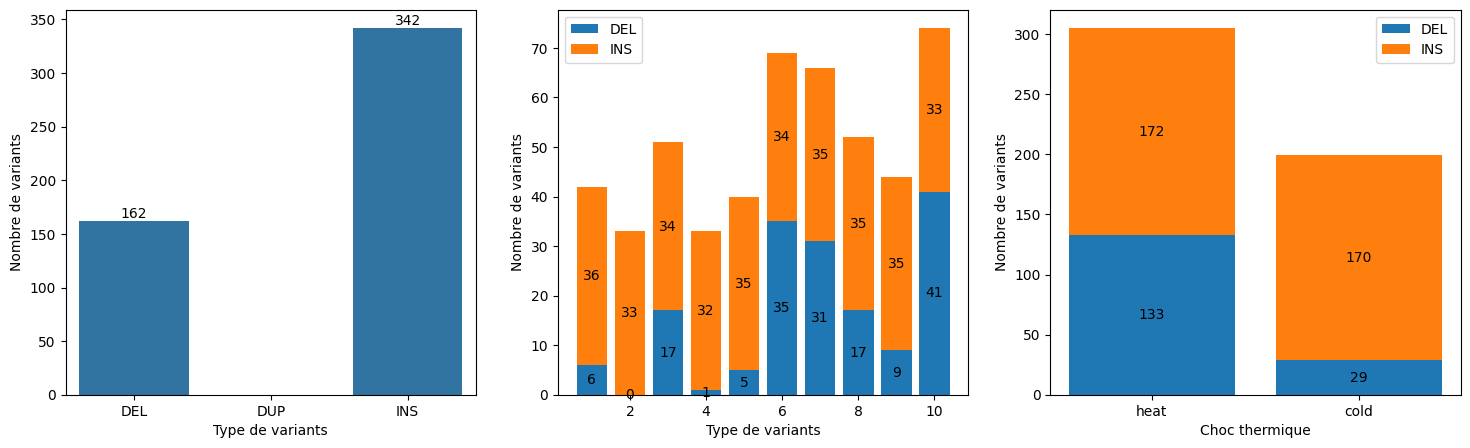

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.countplot(data=data_oi, x="svtype", ax=ax1)
ax1.bar_label(container = ax1.containers[0], fontsize=10)
ax1.set_ylabel('Nombre de variants')
ax1.set_xlabel('Type de variants')

type_count_sample = data_oi.groupby(["svtype", "sample"], observed=True).size()
types = data_oi["svtype"].unique()
samples = data_oi["sample"].unique()
sorted(samples)
bottom = np.zeros(len(samples))
for t in types:
    gc = [type_count_sample[t][s] if s in type_count_sample[t] else 0 for s in samples]
    p = ax2.bar(samples, gc, label=t, bottom=bottom)
    bottom += gc
    ax2.bar_label(p, label_type='center')

ax2.set_ylabel('Nombre de variants')
ax2.set_xlabel('Type de variants')
ax2.legend()


type_count_choc = data_oi.groupby(["svtype", "choc"], observed=True).size()
types = data_oi["svtype"].unique()
chocs = data_oi["choc"].unique()
bottom = np.zeros(len(chocs))
for t in types:
    gc = [type_count_choc[t][c] if c in type_count_choc[t] else 0 for c in chocs]
    p = ax3.bar(chocs, gc, label=t, bottom=bottom)
    bottom += gc
    ax3.bar_label(p, label_type='center')

ax3.set_ylabel('Nombre de variants')
ax3.set_xlabel('Choc thermique')
ax3.legend()

plt.show()

On peut répliquer l'expérience en s'intéressant uniquement aux variants présent dans des ORFs. 

Les insertions qui sont présente n'ont a priori pas d'impacte sur les ORF, ce qui nous comforte dans l'hypothèse que c'est pour les délétions que le choc thermique à été discriminant.

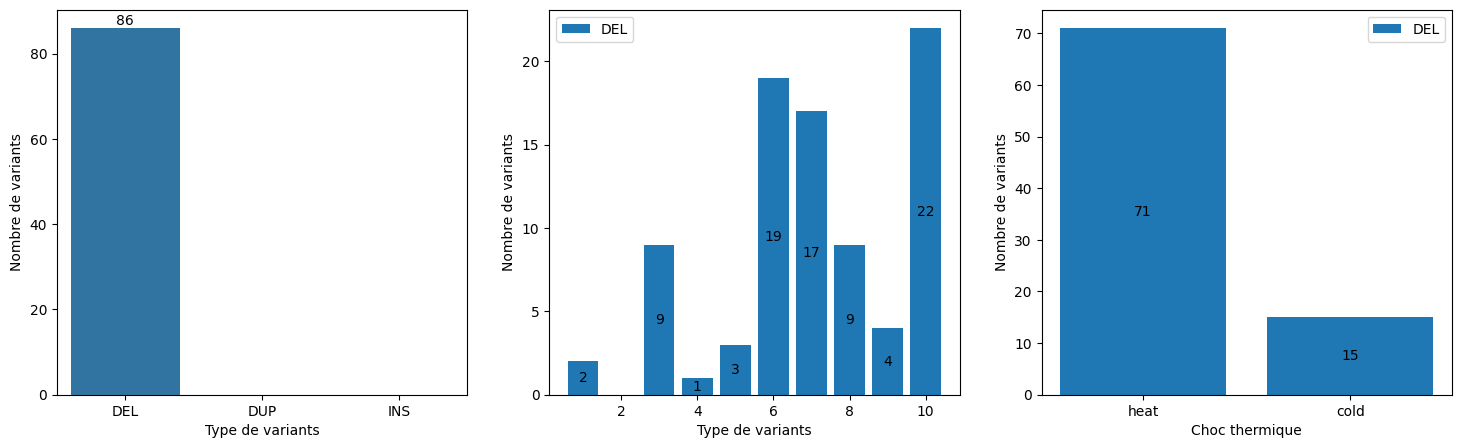

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.countplot(data=data_oi_orf, x="svtype", ax=ax1)
ax1.bar_label(container = ax1.containers[0], fontsize=10)
ax1.set_ylabel('Nombre de variants')
ax1.set_xlabel('Type de variants')

type_count_sample = data_oi_orf.groupby(["svtype", "sample"], observed=True).size()
types = data_oi_orf["svtype"].unique()
samples = data_oi_orf["sample"].unique()
sorted(samples)
bottom = np.zeros(len(samples))
for t in types:
    gc = [type_count_sample[t][s] if s in type_count_sample[t] else 0 for s in samples]
    p = ax2.bar(samples, gc, label=t, bottom=bottom)
    bottom += gc
    ax2.bar_label(p, label_type='center')

ax2.set_ylabel('Nombre de variants')
ax2.set_xlabel('Type de variants')
ax2.legend()


type_count_choc = data_oi_orf.groupby(["svtype", "choc"], observed=True).size()
types = data_oi_orf["svtype"].unique()
chocs = data_oi_orf["choc"].unique()
bottom = np.zeros(len(chocs))
for t in types:
    gc = [type_count_choc[t][c] if c in type_count_choc[t] else 0 for c in chocs]
    p = ax3.bar(chocs, gc, label=t, bottom=bottom)
    bottom += gc
    ax3.bar_label(p, label_type='center')

ax3.set_ylabel('Nombre de variants')
ax3.set_xlabel('Choc thermique')
ax3.legend()

plt.show()

#### B. Tailles et positions des variants

On veut analyser la taille des différents variants ainsi que leurs position sur le génome pour voir si il y a des régions qui se démarquent.